## Read data

In [2]:
options(repr.plot.width=16, repr.plot.height=10)

In [3]:
all_data <- read.csv("Analysis/all_data_dummy.csv")

In [4]:
all_data <- all_data[,2:253]

In [3]:
names(all_data)

[1] "X0........000C1BA7.122E.E411.BC94.F0921C021BF8.1........000FD36B.E520.E511.AE88.F0921C021BF8.2........000FFA74.52CC.E411.8D38.F0921C021BF8.3........0014FADC.81EB.E311.B57F.F0921C021BF8.4........001D0E76.C7CC.E411.8D38.F0921C021BF8...............................................18938....FFF68729.2EBE.E411.949A.F0921C021BF8.18939....FFF95D81.F367.E511.A124.F0921C021BF8.18940....FFFA6165.05C6.E511.8BC0.F0921C021BF8.18941....FFFC2774.05FD.E411.846C.F0921C021BF8.18942....FFFF346E.C372.E511.A124.F0921C021BF8.Name..encounterid..Length..18943..dtype..object"
  [2] "matchsequence"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
  [3] "ageinyears"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
  [4] "los"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
  [5] "icu_los"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
  [6] "pi"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
  [7] "tobaccopacksperday"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
  [8] "tobaccousedyears"                                     

# Modeling without balancing and including Braden metrics

## Stratified partitioning

In [5]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2


In [6]:
train.index <- createDataPartition(all_data$pi, p = .7, list = FALSE)
train_set <- all_data[ train.index,]
test_set  <- all_data[-train.index,]

table(train_set$pi)

table(test_set$pi)


    0     1 
12571   690 


   0    1 
5413  269 

### logistic regression pn the entire dataset

In [6]:
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 3.5.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [72]:
x_training <- select(train_set, -pi)
x_test <- select(test_set, -pi)

In [7]:
library(glmnet)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [75]:
system.time (
    cvlog <- cv.glmnet(data.matrix(x_training), train_set$pi, family = "binomial", type.measure = "class")
    )

   user  system elapsed 
 701.69    1.73  753.82 

#### Plot the result

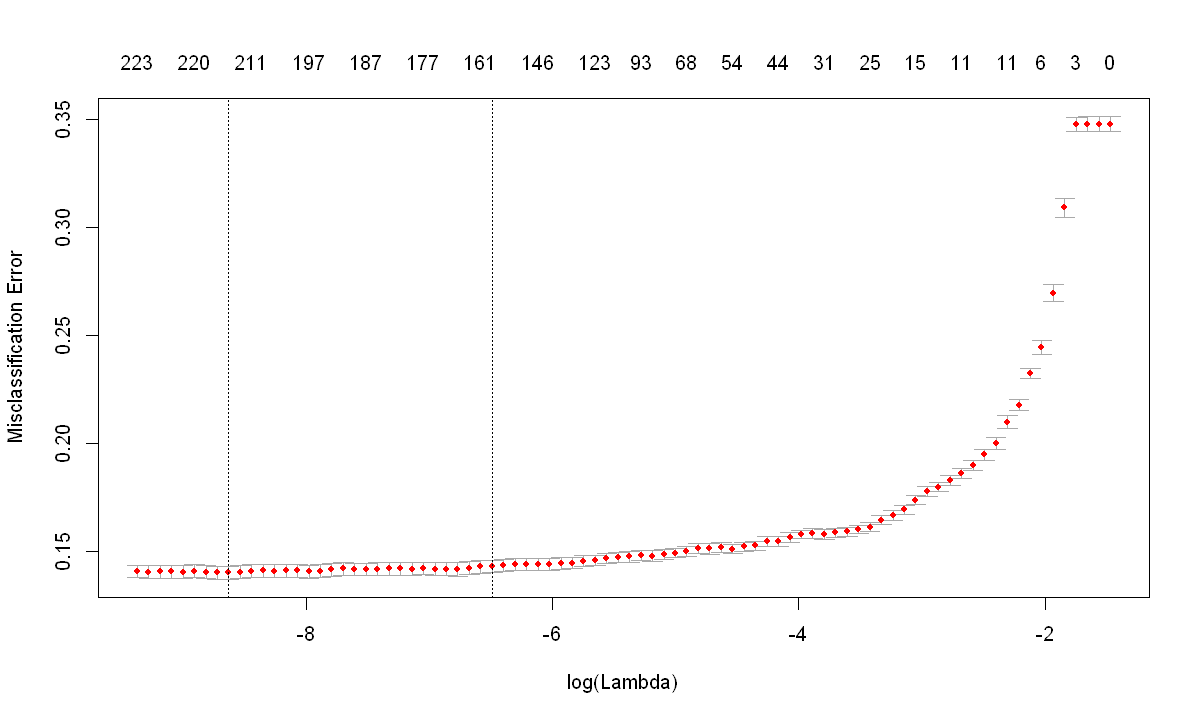

In [76]:
options(repr.plot.width=10, repr.plot.height=6)
plot(cvlog)

#### Get coefficents at lambda.min

In [33]:
pi_coef <- coef(cvlog, s = "lambda.min") %>% as.matrix() %>% exp() %>% round(3)

Get top 20 coefficient

In [36]:
pi_coef[order(-pi_coef[,1])[1:20],]

periop_third_heart_block_yn_used 
                                         26.821 
                        smokelessstatus_Current 
                                          2.698 
                               incontinent_used 
                                          2.469 
                                  paralysis_Yes 
                                          2.081 
                                 weightloss_Yes 
                                          1.751 
             periop_torsades_de_pointes_yn_used 
                                          1.712 
                                     race_Other 
                                          1.646 
                              ethnicity_Unknown 
                                          1.585 
                        diabetescomplicated_Yes 
                                          1.553 
                peripheralvasculardisorders_Yes 
                                          1.527 
                            bloodlossanemia_Yes 
                                          1.498 
               periop_first_heart_block_yn_used 
                                          1.491 
                            valvulardisease_Yes 
                                          1.395 
                                  drugabuse_Yes 
                                          1.310 
                                 depression_Yes 
                                          1.268 
                     congestiveheartfailure_Yes 
                                          1.253 
                             procedure_duration 
                                          1.226 
              pulmonarycirculationdisorders_Yes 
                                          1.218 
race_Native.Hawaiian.and.Other.Pacific.Islander 
                                          1.215 
                  fluidelectrolytedisorders_Yes 
                                          1.185

#### Performance on the training set

In [88]:
y_train_pred <- predict(cvlog, newx = data.matrix(x_training), s = "lambda.min", type = "class")
confusionMatrix(as.factor(y_train_pred), as.factor(train_set$pi),   positive='1')

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 11536  1572
         1  1053  5141
                                          
               Accuracy : 0.864           
                 95% CI : (0.8591, 0.8688)
    No Information Rate : 0.6522          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6947          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7658          
            Specificity : 0.9164          
         Pos Pred Value : 0.8300          
         Neg Pred Value : 0.8801          
             Prevalence : 0.3478          
         Detection Rate : 0.2663          
   Detection Prevalence : 0.3209          
      Balanced Accuracy : 0.8411          
                                          
       'Positive' Class : 1               
                                          

#### Performance on the test set

In [89]:
y_test_pred <- predict(cvlog, newx = data.matrix(x_test), s = "lambda.min", type = "class")
confusionMatrix( as.factor(y_test_pred), as.factor(test_set$pi), positive ="1")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4921  670
         1  474 2207
                                          
               Accuracy : 0.8617          
                 95% CI : (0.8541, 0.8691)
    No Information Rate : 0.6522          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6902          
 Mcnemar's Test P-Value : 8.151e-09       
                                          
            Sensitivity : 0.7671          
            Specificity : 0.9121          
         Pos Pred Value : 0.8232          
         Neg Pred Value : 0.8802          
             Prevalence : 0.3478          
         Detection Rate : 0.2668          
   Detection Prevalence : 0.3241          
      Balanced Accuracy : 0.8396          
                                          
       'Positive' Class : 1               
                                          

## Modeling without balancing and Braden metrics

In [90]:
cvlog_bd = cv.glmnet(data.matrix(select(x_training, -starts_with("braden"))), train_set$pi, family = "binomial", type.measure = "class")

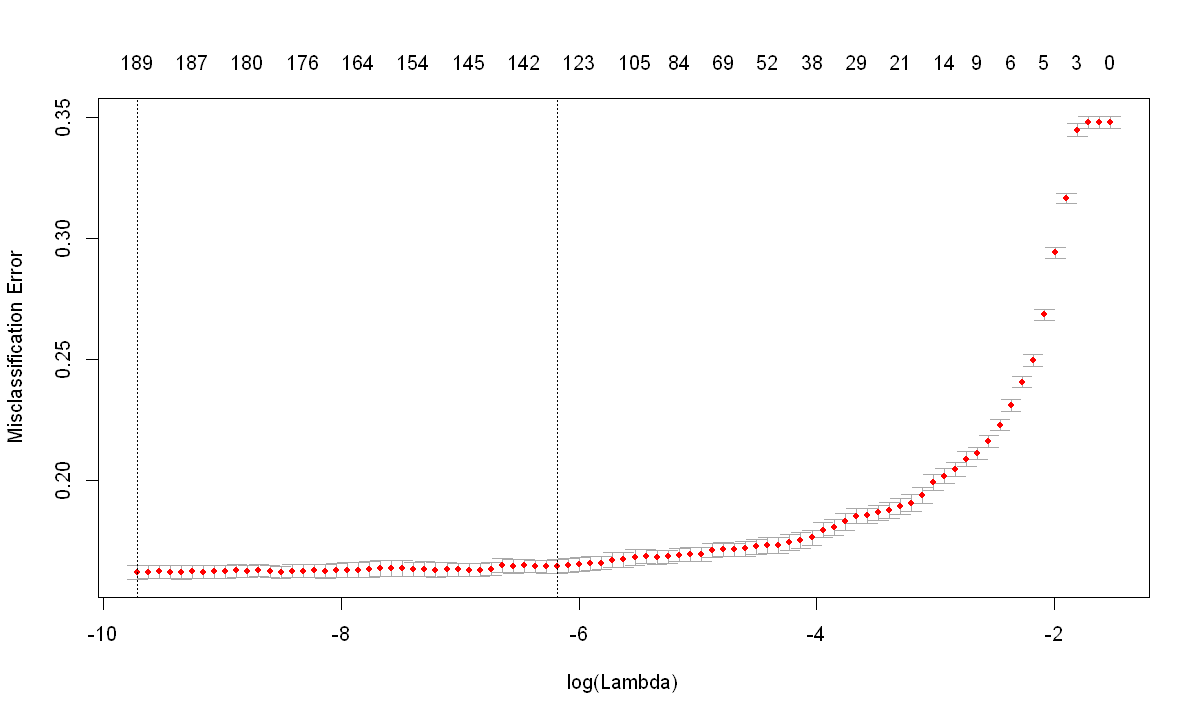

In [91]:
options(repr.plot.width=10, repr.plot.height=6)
plot(cvlog_bd)

#### Get coefficents at lambda.min

In [41]:
pi_coef <- coef(cvlog_bd, s = "lambda.min") %>% as.matrix() %>% exp() %>% round(3)

Get top 20 coefficient

In [42]:
pi_coef[order(-pi_coef[,1])[1:20],]

periop_third_heart_block_yn_used 
                                        158.330 
                               incontinent_used 
                                          4.998 
                                  paralysis_Yes 
                                          4.250 
                        smokelessstatus_Current 
                                          2.638 
             periop_torsades_de_pointes_yn_used 
                                          2.407 
               periop_first_heart_block_yn_used 
                                          2.364 
                                 weightloss_Yes 
                                          2.030 
                                     race_Other 
                                          1.908 
                              ethnicity_Unknown 
                                          1.612 
                        diabetescomplicated_Yes 
                                          1.567 
                peripheralvasculardisorders_Yes 
                                          1.533 
                                 depression_Yes 
                                          1.434 
                            periop_afib_yn_used 
                                          1.410 
                               fecaldevice_used 
                                          1.379 
                            bloodlossanemia_Yes 
                                          1.379 
                     congestiveheartfailure_Yes 
                                          1.355 
          primaryfirst1duplicate_Duplicate.Case 
                                          1.353 
                            valvulardisease_Yes 
                                          1.310 
                           deficiencyanemia_Yes 
                                          1.303 
race_Native.Hawaiian.and.Other.Pacific.Islander 
                                          1.283

#### Performance on the test set

In [108]:
y_test_pred <- predict(cvlog_bd, newx = data.matrix(select(x_test, -starts_with("braden"))), s = "lambda.min", type = "class")
confusionMatrix(as.factor(y_test_pred), as.factor(test_set$pi), positive ="1")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4890  806
         1  505 2071
                                          
               Accuracy : 0.8415          
                 95% CI : (0.8335, 0.8493)
    No Information Rate : 0.6522          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6419          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7198          
            Specificity : 0.9064          
         Pos Pred Value : 0.8040          
         Neg Pred Value : 0.8585          
             Prevalence : 0.3478          
         Detection Rate : 0.2504          
   Detection Prevalence : 0.3114          
      Balanced Accuracy : 0.8131          
                                          
       'Positive' Class : 1               
                                          

## Random Forest Classification

### Modeling with the entire dataset

In [16]:
# install.packages("randomForest")
library(randomForest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin



In [93]:
set.seed(12)
#x_training$pi <- trainingData$pi
train_set$pi <- as.factor(train_set$pi)

In [94]:
system.time(rf.fit <- randomForest(pi~. , data=train_set,importance=TRUE,ntree=200,mtry=50))

   user  system elapsed 
 374.81    0.33  380.18 

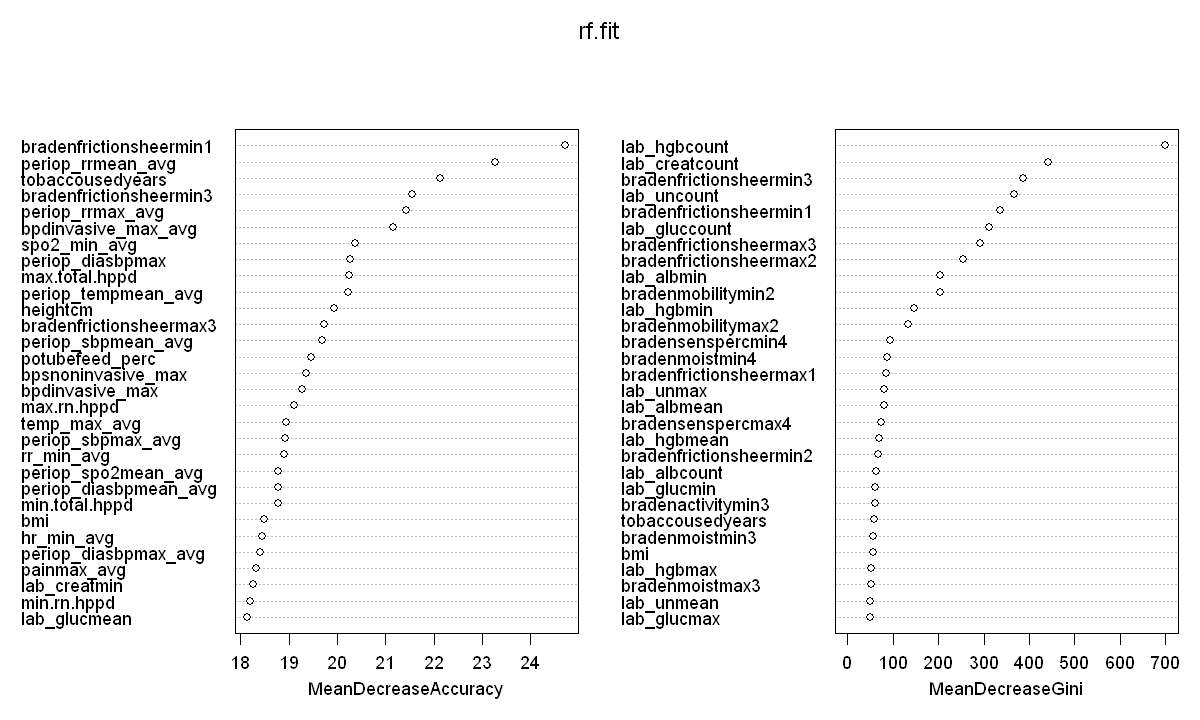

In [109]:
varImpPlot(rf.fit, cex=0.9)

In [102]:
print(rf.fit)


Call:
 randomForest(formula = pi ~ ., data = train_set, importance = TRUE,      ntree = 200, mtry = 50) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 50

        OOB estimate of  error rate: 0.98%
Confusion matrix:
      0    1  class.error
0 12401  188 0.0149336723
1     1 6712 0.0001489647


In [47]:
# save the model to disk
saveRDS(rf.fit, "Analysis/rf_fit_model.rds")

In [44]:
rf.org <- readRDS("Analysis/rf_fit_model.rds")

In [105]:
train_pred <- predict(rf.fit, train_set)
train_pred <- as.factor(train_pred)
confusionMatrix(train_pred, as.factor(train_set$pi), positive = '1')

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12589     0
         1     0  6713
                                     
               Accuracy : 1          
                 95% CI : (0.9998, 1)
    No Information Rate : 0.6522     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.3478     
         Detection Rate : 0.3478     
   Detection Prevalence : 0.3478     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 1          
                                     

#### Evaluate on the test set

In [47]:
table(test_set$pi)


   0    1 
5413  269 

In [97]:
test_pred <- predict(rf.fit, test_set)
test_pred <- as.factor(test_pred)
confusionMatrix(test_pred, as.factor(test_set$pi), positive = '1')

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5317    0
         1   78 2877
                                          
               Accuracy : 0.9906          
                 95% CI : (0.9882, 0.9925)
    No Information Rate : 0.6522          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9793          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 1.0000          
            Specificity : 0.9855          
         Pos Pred Value : 0.9736          
         Neg Pred Value : 1.0000          
             Prevalence : 0.3478          
         Detection Rate : 0.3478          
   Detection Prevalence : 0.3572          
      Balanced Accuracy : 0.9928          
                                          
       'Positive' Class : 1               
                                          

### Cross validation

In [38]:
fitControl <- trainControl(method = "cv", number = 3)

In [21]:
train_set$pi <- as.factor(train_set$pi)

In [33]:
training <- select(train_set,-c("periop_pea_yn_used","periop_pea_yn_perc"))

In [39]:
set.seed(825)
rfFit1 <- caret::train(pi ~ ., data = training, method = "rf", trControl = fitControl)

ERROR: Error in help(dplyr::select): 'topic' should be a name, length-one character vector or reserved word


In [37]:
which(apply(train_set, 2, function (x) length(unique(x))) ==1)

periop_pea_yn_used periop_pea_yn_perc 
               114                128

### Modeling without Braden data

In [98]:
wo_braden <- select(train_set, -starts_with("braden"))
system.time(rf.fit.bd <- randomForest(pi~. , data=wo_braden,importance=TRUE,ntree=200,mtry=50))

   user  system elapsed 
 311.50    0.51  316.99 

 num [1:205, 1:2] 13.7 27.5 17.3 12.8 18.1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:205] "matchsequence" "ageinyears" "los" "icu_los" ...
  ..$ : chr [1:2] "MeanDecreaseAccuracy" "MeanDecreaseGini"


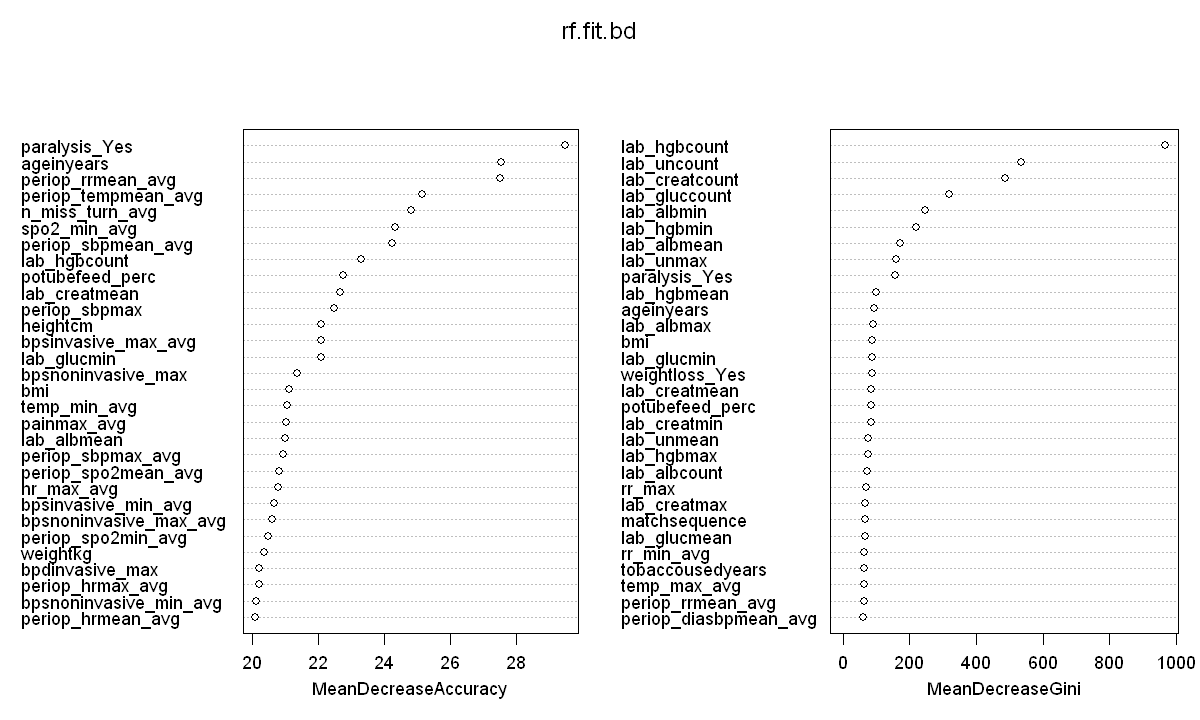

In [110]:
options(repr.plot.width=10, repr.plot.height=6)
str(varImpPlot(rf.fit.bd, cex=0.9))

In [103]:
print(rf.fit.bd)


Call:
 randomForest(formula = pi ~ ., data = wo_braden, importance = TRUE,      ntree = 200, mtry = 50) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 50

        OOB estimate of  error rate: 0.79%
Confusion matrix:
      0    1  class.error
0 12439  150 0.0119151640
1     2 6711 0.0002979294


In [104]:
print(rf.fit)


Call:
 randomForest(formula = pi ~ ., data = train_set, importance = TRUE,      ntree = 200, mtry = 50) 
               Type of random forest: classification
                     Number of trees: 200
No. of variables tried at each split: 50

        OOB estimate of  error rate: 0.98%
Confusion matrix:
      0    1  class.error
0 12401  188 0.0149336723
1     1 6712 0.0001489647


In [106]:
wo_braden_train <- select(train_set, -starts_with("braden"))
train_pred <- predict(rf.fit.bd, wo_braden_train)
train_pred <- as.factor(train_pred)
confusionMatrix(train_pred, as.factor(train_set$pi), positive='1')

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 12589     0
         1     0  6713
                                     
               Accuracy : 1          
                 95% CI : (0.9998, 1)
    No Information Rate : 0.6522     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.3478     
         Detection Rate : 0.3478     
   Detection Prevalence : 0.3478     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 1          
                                     

#### Evaluate on the test set

In [101]:
wo_braden_test <- select(test_set, -starts_with("braden"))
test_pred <- predict(rf.fit.bd, wo_braden_test)
test_pred <- as.factor(test_pred)
confusionMatrix(test_pred, as.factor(test_set$pi), positive='1')

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5346    0
         1   49 2877
                                          
               Accuracy : 0.9941          
                 95% CI : (0.9922, 0.9956)
    No Information Rate : 0.6522          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.987           
 Mcnemar's Test P-Value : 7.025e-12       
                                          
            Sensitivity : 1.0000          
            Specificity : 0.9909          
         Pos Pred Value : 0.9833          
         Neg Pred Value : 1.0000          
             Prevalence : 0.3478          
         Detection Rate : 0.3478          
   Detection Prevalence : 0.3537          
      Balanced Accuracy : 0.9955          
                                          
       'Positive' Class : 1               
                                          

## Modeling with data rebalancing

In [8]:
set.seed(1234)
library(unbalanced)

output <- as.factor(all_data$pi)
input <- select(all_data, -pi)

#configure sampling parameters
#ubConf <- list(type="ubUnder", k=10, perc=50, method="percPos", w=NULL)

Loading required package: mlr
Loading required package: ParamHelpers

Attaching package: 'mlr'

The following object is masked from 'package:caret':

    train

Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel


In [9]:
#ubSMOTE(X, Y, perc.over = 200, k = 5, perc.under = 200, verbose = TRUE)
#ubOver(X, Y, k = 0, verbose=TRUE)
balanced_data = ubOver(X=input, Y=output, k=10)

In [10]:
balanced_data <- data.frame(balanced_data$X, pi=balanced_data$Y)
table(balanced_data$pi)


    0     1 
17984  9590 

In [54]:
#apply oversampling
#data <- ubUnder(X=input, Y=output, perc = 20, method = "percPos", w = NULL)
#oversampled dataset

### Stratified sampling

In [11]:
train.index <- createDataPartition(balanced_data$pi, p = .7, list = FALSE)
train_set <- balanced_data[ train.index,]
test_set  <- balanced_data[-train.index,]

table(train_set$pi)

table(test_set$pi)


    0     1 
12589  6713 


   0    1 
5395 2877 